## Quantile Function

In probability theory and statistics, the cumulative distribution function (CDF) of a real-valued random variable {\displaystyle X}X, or just distribution function of {\displaystyle X}X, evaluated at {\displaystyle x}x, is the probability that {\displaystyle X}X will take a value less than or equal to {\displaystyle x}x.[1]

In the case of a scalar continuous distribution, it gives the area under the probability density function from minus infinity to {\displaystyle x}x. Cumulative distribution functions are also used to specify the distribution of multivariate random variables.


The cumulative distribution function of a real-valued random variable {\displaystyle X}X is the function given by[2]:p. 77

{\displaystyle F_{X}(x)=\operatorname {P} (X\leq x)}{\displaystyle F_{X}(x)=\operatorname {P} (X\leq x)}
 

where the right-hand side represents the probability that the random variable {\displaystyle X}X takes on a value less than or equal to {\displaystyle x}x. The probability that {\displaystyle X}X lies in the semi-closed interval {\displaystyle (a,b]}(a,b], where {\displaystyle a<b}a<b, is therefore[2]:p. 84

{\displaystyle \operatorname {P} (a<X\leq b)=F_{X}(b)-F_{X}(a)}{\displaystyle \operatorname {P} (a<X\leq b)=F_{X}(b)-F_{X}(a)}


In the definition above, the "less than or equal to" sign, "≤", is a convention, not a universally used one (e.g. Hungarian literature uses "<"), but the distinction is important for discrete distributions. The proper use of tables of the binomial and Poisson distributions depends upon this convention. Moreover, important formulas like Paul Lévy's inversion formula for the characteristic function also rely on the "less than or equal" formulation.



With reference to a continuous and strictly monotonic distribution function, for example the cumulative distribution function {\displaystyle F_{X}\colon R\to [0,1]}{\displaystyle F_{X}\colon R\to [0,1]} of a random variable X, the quantile function Q returns a threshold value x below which random draws from the given c.d.f would fall p percent of the time.

In terms of the distribution function F, the quantile function Q returns the value x such that

{\displaystyle F_{X}(x):=\Pr(X\leq x)=p.\,}F_{X}(x):=\Pr(X\leq x)=p.\,

The cumulative distribution function (shown as F(x)) gives the p values as a function of the q values. The quantile function does the opposite: it gives the q values as a function of the p values.
Another way to express the quantile function is

{\displaystyle Q(p)\,=\,\inf \left\{x\in \mathbb {R} :p\leq F(x)\right\}}Q(p)\,=\,\inf \left\{x\in {\mathbb  {R}}:p\leq F(x)\right\}
for a probability 0 < p < 1. Here we capture the fact that the quantile function returns the minimum value of x from amongst all those values whose c.d.f value exceeds p, which is equivalent to the previous probability statement in the special case that the distribution is continuous. Note that the infimum function can be replaced by the minimum function, since the distribution function is right-continuous and weakly monotonically increasing.

The quantile is the unique function satisfying the Galois inequalities

{\displaystyle Q(p)\leq x}{\displaystyle Q(p)\leq x} if and only if {\displaystyle p\leq F(x)}{\displaystyle p\leq F(x)}
If the function F is continuous and strictly monotonically increasing, then the inequalities can be replaced by equalities, and we have:

{\displaystyle Q=F^{-1}}Q=F^{{-1}}
In general, even though the distribution function F may fail to possess a left or right inverse, the quantile function Q behaves as an "almost sure left inverse" for the distribution function, in the sense that

{\displaystyle Q(F(X))=X}{\displaystyle Q(F(X))=X} almost surely.


Quantile functions are used in both statistical applications and Monte Carlo methods.

The quantile function is one way of prescribing a probability distribution, and it is an alternative to the probability density function (pdf) or probability mass function, the cumulative distribution function (cdf) and the characteristic function. The quantile function, Q, of a probability distribution is the inverse of its cumulative distribution function F. The derivative of the quantile function, namely the quantile density function, is yet another way of prescribing a probability distribution. It is the reciprocal of the pdf composed with the quantile function.

For statistical applications, users need to know key percentage points of a given distribution. For example, they require the median and 25% and 75% quartiles as in the example above or 5%, 95%, 2.5%, 97.5% levels for other applications such as assessing the statistical significance of an observation whose distribution is known; see the quantile entry. Before the popularization of computers, it was not uncommon for books to have appendices with statistical tables sampling the quantile function.[1] Statistical applications of quantile functions are discussed extensively by Gilchrist.[2]

Monte-Carlo simulations employ quantile functions to produce non-uniform random or pseudorandom numbers for use in diverse types of simulation calculations. A sample from a given distribution may be obtained in principle by applying its quantile function to a sample from a uniform distribution. The demands, for example, of simulation methods in modern computational finance are focusing increasing attention on methods based on quantile functions, as they work well with multivariate techniques based on either copula or quasi-Monte-Carlo methods[3] and Monte Carlo methods in finance.





Inverse transform sampling (also known as inversion sampling, the inverse probability integral transform, the inverse transformation method, Smirnov transform, or the golden rule[1]) is a basic method for pseudo-random number sampling, i.e., for generating sample numbers at random from any probability distribution given its cumulative distribution function.

Inverse transformation sampling takes uniform samples of a number {\displaystyle u}u between 0 and 1, interpreted as a probability, and then returns the largest number {\displaystyle x}x from the domain of the distribution {\displaystyle P(X)}P(X) such that {\displaystyle P(-\infty <X<x)\leq u}{\displaystyle P(-\infty <X<x)\leq u}. For example, imagine that {\displaystyle P(X)}P(X) is the standard normal distribution with mean zero and standard deviation one. The table below shows samples taken from the uniform distribution and their representation on the standard normal distribution.

Transformation from uniform sample to normal
{\displaystyle u}u	{\displaystyle F^{-1}(u)}{\displaystyle F^{-1}(u)}
.5	0
.975	1.95996
.995	2.5758
.999999	4.75342
1-2^{-52}	8.12589

Inverse transform sampling for normal distribution
We are randomly choosing a proportion of the area under the curve and returning the number in the domain such that exactly this proportion of the area occurs to the left of that number. Intuitively, we are unlikely to choose a number in the far end of tails because there is very little area in them which would require choosing a number very close to zero or one.

Computationally, this method involves computing the quantile function of the distribution — in other words, computing the cumulative distribution function (CDF) of the distribution (which maps a number in the domain to a probability between 0 and 1) and then inverting that function. This is the source of the term "inverse" or "inversion" in most of the names for this method. Note that for a discrete distribution, computing the CDF is not in general too difficult: we simply add up the individual probabilities for the various points of the distribution. For a continuous distribution, however, we need to integrate the probability density function (PDF) of the distribution, which is impossible to do analytically for most distributions (including the normal distribution). As a result, this method may be computationally inefficient for many distributions and other methods are preferred; however, it is a useful method for building more generally applicable samplers such as those based on rejection sampling.

For the normal distribution, the lack of an analytical expression for the corresponding quantile function means that other methods (e.g. the Box–Muller transform) may be preferred computationally. It is often the case that, even for simple distributions, the inverse transform sampling method can be improved on:[2] see, for example, the ziggurat algorithm and rejection sampling. On the other hand, it is possible to approximate the quantile function of the normal distribution extremely accurately using moderate-degree polynomials, and in fact the method of doing this is fast enough that inversion sampling is now the default method for sampling from a normal distribution in the statistical package R.[3]




The problem that the inverse transform sampling method solves is as follows:

Let {\displaystyle X}X be a random variable whose distribution can be described by the cumulative distribution function {\displaystyle F_{X}}F_{X}.
We want to generate values of {\displaystyle X}X which are distributed according to this distribution.
The inverse transform sampling method works as follows:

Generate a random number {\displaystyle u}u from the standard uniform distribution in the interval {\displaystyle [0,1]}[0,1], e.g. from {\displaystyle U\sim \mathrm {Unif} [0,1].}{\displaystyle U\sim \mathrm {Unif} [0,1].}
Find the inverse of the desired CDF, e.g. {\displaystyle F_{X}^{-1}(x)}{\displaystyle F_{X}^{-1}(x)}.
Compute {\displaystyle X=F_{X}^{-1}(u)}{\displaystyle X=F_{X}^{-1}(u)}. The computed random variable {\displaystyle X}X has distribution {\displaystyle F_{X}(x)}F_X(x).
Expressed differently, given a continuous uniform variable {\displaystyle U}U in {\displaystyle [0,1]}[0,1] and an invertible cumulative distribution function {\displaystyle F_{X}}F_{X}, the random variable {\displaystyle X=F_{X}^{-1}(U)}{\displaystyle X=F_{X}^{-1}(U)} has distribution {\displaystyle F_{X}}F_{X} (or, {\displaystyle X}X is distributed {\displaystyle F_{X}}F_{X}).

A treatment of such inverse functions as objects satisfying differential equations can be given.[4] Some such differential equations admit explicit power series solutions, despite their non-linearity.[citation needed

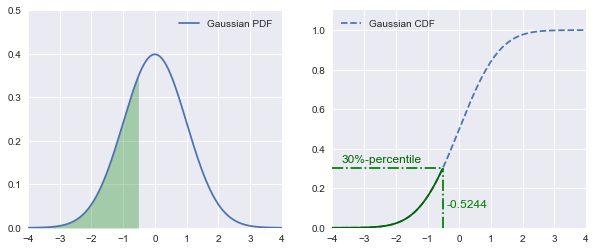

<Figure size 576x396 with 0 Axes>

In [23]:
import numpy
from scipy.stats import norm
from matplotlib import pyplot as plt
plt.style.use('seaborn')

x = numpy.arange(-4, 4, 0.01)
y = norm.pdf(x)
xf = numpy.arange(-4, -.5244, 0.01)
yf = norm.pdf(xf)

yct = norm.cdf(x)
yc = norm.cdf(xf)

y1 = norm.cdf(-0.5244)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

ax1.plot(x, y, label='Gaussian PDF')
ax1.fill_between(xf, 0, yf, color='green', alpha=0.3)
ax1.set_xlim(-4, 4)
ax1.set_ylim(0, 0.5)
ax1.legend()
ax1.grid(True)

ax2.plot(x, yct, linestyle='--', label='Gaussian CDF')
ax2.plot(xf, yc, color='darkgreen')
ax2.text(-3.7, 0.33, r'30%-percentile', fontsize=12, color='darkgreen')
ax2.text(-0.4, 0.1, r'-0.5244', fontsize=12, color='green')
plt.plot((-4, -0.5244), (y1, y1), color="green", linestyle='-.')
plt.plot((-0.5244, -0.5244), (0., y1), color="green", linestyle='-.')
ax2.set_xlim(-4, 4)
ax2.set_ylim(0, 1.1)
ax2.legend()

plt.show()
plt.savefig("percentile.png")

The definition of a \emph{copula} is: a multivariate distribution $C(U_1, U_2, \ldots, U_n)$ such that marginalizing gives $U_i \approx$~Uniform(0,1). 
Despite this obscure and daunting sentence the concept is quite simple so let's try to clarify it a bit and at the end we will see what role copulas played in the 2008 financial crisis.

### Example Problem Case
Imagine we measure two variables that are non-normally distributed and correlated. For example, we look at various rivers and for every river we look at the maximum level of that river over a certain time-period. In addition, we also count how many months each river caused flooding. For the probability distribution of the maximum level of the river we know that maximums are \href{}{\emph{Grumbel}} distributed, while the number of flooding can be modelled according to a \href{}{\emph{Beta}} distribution.

Clearly it is pretty reasonable to assume that the maximum level and the number of floodings is going to be correlated, however we don't know how we could model that correlated probability distribution. Above we only specified the distributions for individual variables, irrespective of the other one (i.e. the marginals), in reality we are dealing with a joint distribution of both of these together. 

And here is where copulas come to our rescue.

Copulas essentially allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together and thus allows us to specify the correlation separately. The copula is that coupling function.

Before going into them, we must first learn how we can transform arbitrary random variables to uniform and back.

### Distribution Transformation
The technique we are going to use to transform every random variables to uniform and viceversa is called \emph{probability integral transform}. We won't go into the details but we will just show few examples of how this can be done in \texttt{python} and we will use the \texttt{scipy.stats} module to do the job.

So first, we sample uniformly distributed values between 0 and 1:

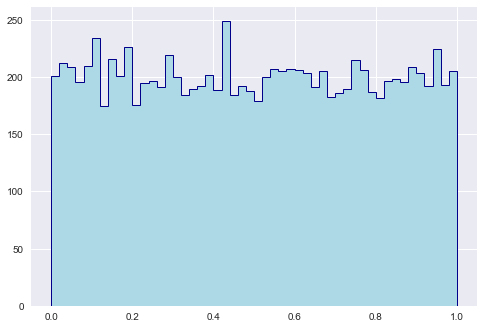

In [52]:
from scipy import stats
from matplotlib import pyplot as plt

x = stats.uniform(0, 1).rvs(10000)
plt.style.use('seaborn')
plt.hist(x, histtype='stepfilled', lw=1, ec='darkblue', color="lightblue", bins=50)
plt.show()

Next we want to transform these samples so that instead of uniform they are normally distributed. The transform that does this is the inverse of the cumulative density function (CDF) of the normal distribution which we can get in \texttt{scipy.stats} with \texttt{ppf}.

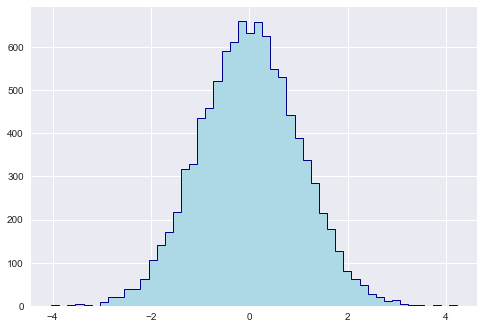

In [53]:
norm = stats.distributions.norm() # get the normal distribution definition
x_trans = norm.ppf(x)

plt.hist(x_trans, bins=50, histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
plt.show()

If we plot them togheter in a 2D plot we can get a sense of what is going on using the inverse CDF transformation:

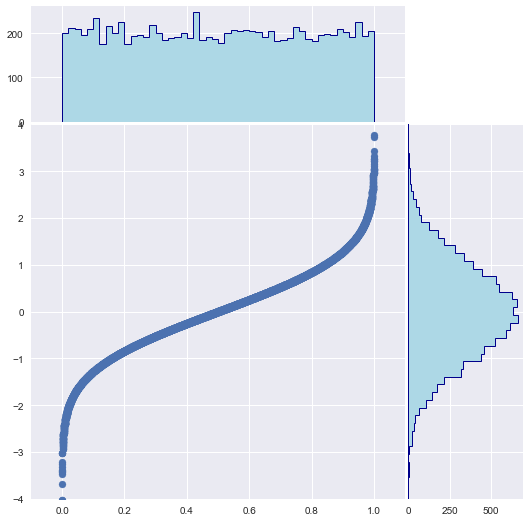

In [56]:
import numpy as np

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x, bins=50,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x_trans, bins=50, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

The inverse CDF stretches the outer regions of the uniform to yield a normal distribution. The nice thing of the technique is that it can be done for any arbitrary (univariate) probability distributions, like Beta or Gumbel:

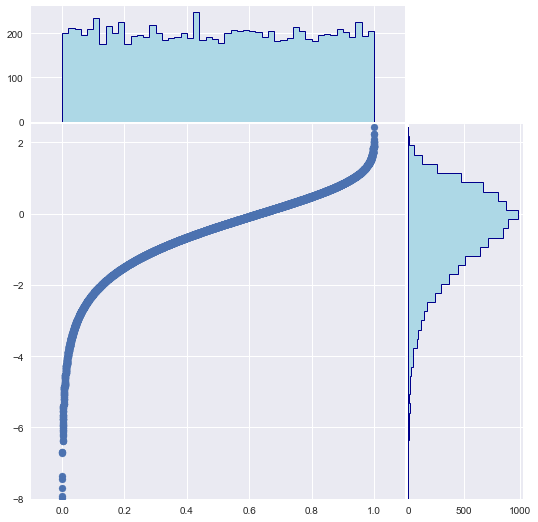

In [57]:
gumbel = stats.distributions.gumbel_l()
x_trans = gumbel.ppf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, x_trans)

ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-8, 2.5))

ax_histx.hist(x, bins=50,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x_trans, bins=50, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Clearly to do the opposite transformation from an arbitray distribution to the uniform(0, 1) we can just apply the inverse of the inverse CDF, the CDF itself...

## Adding Correlation with Gaussian Copulas

How does this help us with our problem of creating a custom joint probability distriution ? We are actually almost done already, we know how to convert anything uniformly distributed to an arbitrary probability distribution. So that means we need to generate uniformly distributed data with the correlation we want and then transform the marginals into the desired distributions. How do we do that ? We simulate from a multivariarte Gaussian with the specific corrrelation structure, transform so that the marginals are uniform, and then transform the uniform marginals to whatever we like.

Generate random samples from multivariate normal with correlation .5:

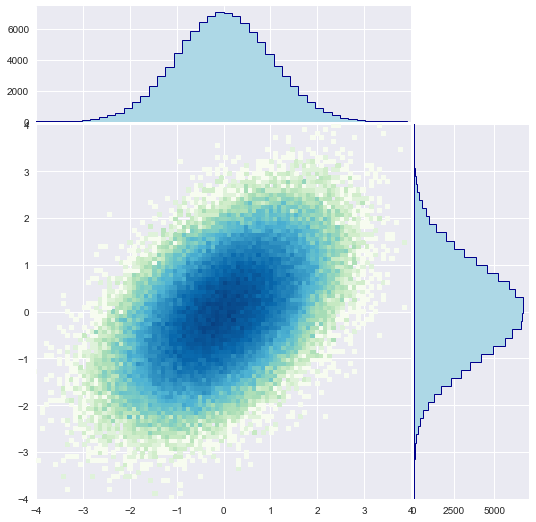

In [59]:
# this import is for plotting
from matplotlib import colors

mvnorm = stats.multivariate_normal(mean=[0, 0] , cov=[[1, 0.5],
                                                      [0.5, 1]])
x = mvnorm.rvs(100000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x[:, 0], x[:, 1], bins=100, norm=colors.LogNorm(), cmap="GnBu")
ax_scatter.grid(True)
ax_scatter.set_xlim((-4, 4))
ax_scatter.set_ylim((-4, 4))

ax_histx.hist(x[:, 0], bins=50,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x[:, 1], bins=50, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Now use what we have just seen to \emph{uniformify} the marginals:

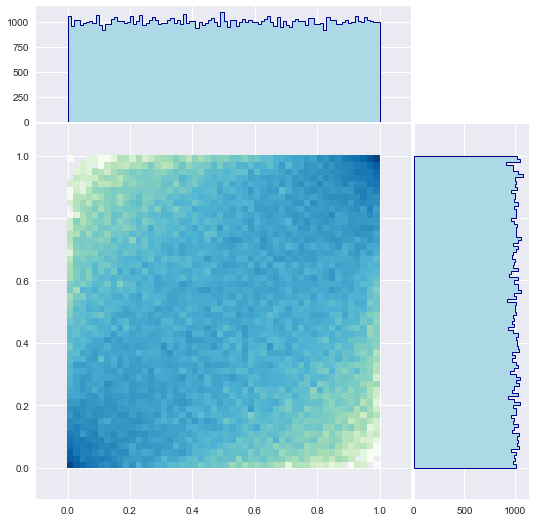

In [61]:
norm = stats.norm()
x_unif = norm.cdf(x)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x_unif[:, 0], x_unif[:, 1], bins=50, norm=colors.LogNorm(), cmap="GnBu")
ax_scatter.grid(True)
ax_scatter.set_xlim((-0.1, 1.1))
ax_scatter.set_ylim((-0.1, 1.1))

ax_histx.hist(x_unif[:, 0], bins=100,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x_unif[:, 1], bins=100, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

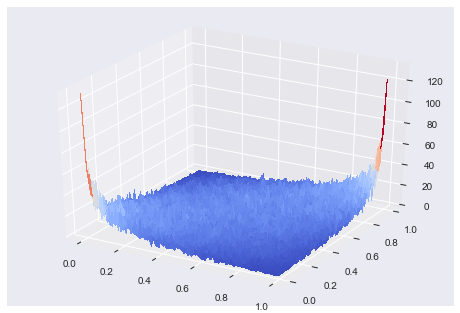

In [63]:
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal, norm
import numpy as np

mvnorm = multivariate_normal(mean=[0, 0] , cov=[[1, 0.5], 
                                            [0.5, 1]])
x = mvnorm.rvs(100000)
normal = norm()
x_unif = normal.cdf(x)

#plt.contour(x_unif[:, 0], x_unif[:, 1], 
#           bins=50)

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
XBIN = np.array([i/100 for i in range(0, 101)])
X = np.arange(0, 1, 0.01)
Y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(X, Y)
h, XBIN, XBIN= np.histogram2d(x_unif[:, 0], x_unif[:, 1], bins=(XBIN, XBIN))

# Plot the surface.
surf = ax.plot_surface(X, Y, h, cmap=cm.coolwarm,
                 linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

This scatter plot above is usually how copulas are visualized.
Finally we can just transform the marginals again from uniform to what we want (e.g. Gumbel and Beta): 

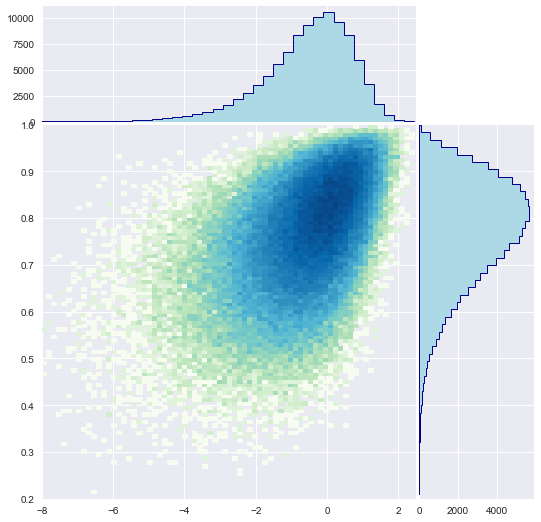

In [66]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=3)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)

ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1_trans, x2_trans, bins=100, norm=colors.LogNorm(), cmap="GnBu")
ax_scatter.grid(True)
ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1_trans, bins=50,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x2_trans, bins=50, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

It is now interesting to compare with the joint distribution without correlations:

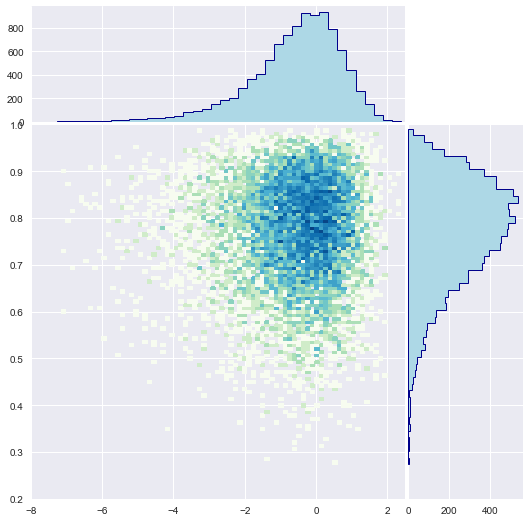

In [67]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hist2d(x1, x2, bins=100, norm=colors.LogNorm(), cmap="GnBu")
ax_scatter.grid(True)
ax_scatter.set_xlim((-8, 2.5))
ax_scatter.set_ylim((0.2, 1))

ax_histx.hist(x1, bins=50,histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")
ax_histy.hist(x2, bins=50, orientation='horizontal',histtype='stepfilled', lw=1, ec='darkblue', color="lightblue")

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Using the uniform distribution as a common base for our transformations we can easily introduce correlations and flexibly construct complex probability distributions. Clearly this is directly extendeable to higher dimensional distributions as well.

## Application to Finance
In credit derivative valuation and credit risk management, one of the fundamentally important issues is the estimation of default probabilities and their correlations. For this, generally speaking, there are two ways: using historical default data or using mathematical models. 

Historical default data has played an important role in the estimation of default probabilities. However, because default events are rare, there is very limited default data available. Moreover, historical data reflects the historical default pattern only and it may not be a proper indicator of the future. This makes the estimation of default probabilities from historical data difficult and inexact. To use this same data to estimate default correlations is even more difficult and more inexact. 

The market trend now is towards more and more to the use of mathematical models that don't rely on historical default data. In the previous chapter we have seen how it is possible to derive default probabilities from market data. Before going into the details of the application of the copula to default probabilities let's introduce two more kind of contracts.

### Basket Default Swaps
A basket default swap is a credit derivative on a portfolio of reference entities. The
simplest basket default swaps are first-to-default swaps, second-to-default swaps,
and nth-to-default swaps. With respect to a basket of reference entities, a first-to-default swap provides insurance for only the first default, a second-to-default swap
provides insurance for only the second default, an nth-to-default swap provides
insurance for only the nth default. For example, in an nth-to-default swap, the
protection seller does not make a payment to the protection buyer for the first n−1
defaulted reference entities, and makes a payment for the nth defaulted reference
entity. Once there is a payment upopn the default of the nth defaulted reference
entity, the swap terminates. 

### Collateralized Debt Obligation
A collateralized debt obligation (CDO) is a security backed by a diversified pool of
one or more kinds of debt obligations such as bonds, loans, credit default swaps or
structured products (mortgage-backed securities, asset-backed securities, and even
other CDOs). A CDO can be initiated by one or more of the following: banks,
nonbank financial institutions, and asset management companies, is referred to as
the sponsor. The sponsor of a CDO creates a company so-called the special purpose
vehicle (SPV). The SPV works as an independent entity. In this way, CDO investors
are isolated from the credit risk of the sponsor. Moreover, the SPV is responsible
for the administration. The SPV obtains the credit risk exposure by purchasing
debt obligations (bonds or residential and commercial loans) or selling CDSs; it
transfers the credit risk by issuing debt obligations (tranches/credit-linked notes).
The investors in the tranches of a CDO have the ultimate credit risk exposure to
the underlying reference entities.
The SPV issues four kinds of tranches. Each tranche has
an attachment percentage and a detachment percentage. When the cumulative
percentage loss of the portfolio reaches the attachment percentage, investors
in the tranche start to lose their principal, and when the cumulative percentage loss
of principal reaches the detachment percentage, the investors in the tranche lose all
their principal and no further loss can occur to them.

In the literature, tranches of a CDO are classified as subordinate/equity tranche,
mezzanine tranches, and senior tranches according to their subordinate levels. 
Because the equity tranche is extremely
risky, the sponsor of a CDO holds the equity tranche and the SPV sells other tranches
to investors.

### Calculating first-to-default, nth-to-default and all-to-default probabilities

#### Independent Defaults
If the default times of the names of a basket are independent, first-to-default, nth-to-default, all-to-default probabilities can be calculated through multiplication and integration of the default probability curves of the basket components. 

As an example, we consider the second-to-default probability of a 4-name basket. Let $\tau_i$ be the default time of name $i$ and $F_i(t)$ its distribution. Then the probability that name 1 defaults second in the basket before time $t$ and before the counter-party defaults: 

$$P((\tau_2\lt\tau_1)\cap (\tau_1\lt t)\cap (\tau_1\lt\tau_3)\cap (\tau_1\lt\tau_4)) +
P((\tau_3\lt\tau_1)\cap (\tau_1\lt t)\cap (\tau_1\lt\tau_2)\cap (\tau_1\lt\tau_4)) =
\int_0^t{F_2 (s)\cdot (1-F_3 (s)) \cdot (1-F_4 (s))~dF_1(s)} +  \int_0^t{F_3 (s)\cdot (1-F_2 (s)) \cdot (1-F_4 (s))~dF_1(s)}$$

The formula for nth-to-default probability before the counterparty defaults in a general basket can be derived similarly. However, complexity increases as the number of names increases.
The above method can also apply to derive the formula of all-to-default probability before the counter-party defaults. This is clearly much simpler than the nth-to-default case.

Suppose the default probabilities of three companies, A, B and C are given as in the following table:

\begin{center}
\begin{tabular}[|c|c|c|c|]
time in years & A & B & C \\
\hline
0 & 0 & 0 & 0 \\
1 & 0.022032 & 0.0317 & 0.035 \\
2 & 0.046242 & 0.0655 & 0.075 \\
3 & 0.07266 & 0.1022 & 0.121 \\
4 & 0.101233 & 0.142 & 0.153 \\
5 & 0.131885 & 0.1752 & 0.205 \\
\end{tabular}
\end{center}
and suppose that the default events of the three companies are independent. Using linear interpolation for default probability curves, let's get the table of first-to-default probabilities for the three companies.

<img src="default_A.png">

The default probabilities are linear in each time interval so the integral above can be solved by substitution:

$$ \int_{x_0}^{x_1}{(1-F_B(x))(1-F_C(x))dF_A(x)}$$

Setting $t=m_A x + q_A$ it becomes with $m_A, q_A$ are the parameters of the line joining the default probabilities of company A:

$$ \int_{m_A x_0 + q_A}^{m_A x_1 + q_A}{(1-F_B(x(t)))(1-F_C(x(t)))dt}~~~~~~\textrm{, with}~x(t) = \cfrac{t -q_A}{m_A} $$
and similarly for company B and C.

To convert it into python we can use \texttt{scipy.integrate.quad} to perform the integral and \texttt{numpy.interp} to determine the intermediate default probabilities.

In [15]:
from scipy.integrate import quad
from numpy import interp

default_rates = {"A":(0, 0.022032, 0.046242, 0.07266, 0.101233, 0.131885), # company A
                 "B":(0, 0.0317, 0.0655, 0.1022, 0.142, 0.1752), # company B
                 "C":(0, 0.035, 0.075, 0.121, 0.153, 0.205)} # company C

def func(x, default, companies, t):
    m = default[companies[0]][t] - default[companies[0]][t-1]
    q = default[companies[0]][t-1] - m * (t-1)
    t = (x-q)/m
    F2 = 1 - interp(t, range(len(default[companies[1]])), default[companies[1]])
    F3 = 1 - interp(t, range(len(default[companies[2]])), default[companies[2]])
    return F2*F3

def integral(default, companies, t):
    return quad(func, 0, default[companies[0]][t], args=(default, companies, t))[0]
                 
for companies in [("A", "B", "C"), ("B", "A", "C"), ("C", "A", "B")]:
    prob = 0
    for t in range(1, 6):
        prob = integral(default_rates, companies, t)
        print ("First to default prob at time ({}) for company {}: {:.5f}".format(t, companies[0], prob))


First to default prob at time (1) for company A: 0.02131
First to default prob at time (2) for company A: 0.04301
First to default prob at time (3) for company A: 0.06460
First to default prob at time (4) for company A: 0.08573
First to default prob at time (5) for company A: 0.10606
First to default prob at time (1) for company B: 0.03080
First to default prob at time (2) for company B: 0.06160
First to default prob at time (3) for company B: 0.09245
First to default prob at time (4) for company B: 0.12315
First to default prob at time (5) for company B: 0.15018
First to default prob at time (1) for company C: 0.03407
First to default prob at time (2) for company C: 0.07071
First to default prob at time (3) for company C: 0.10986
First to default prob at time (4) for company C: 0.13879
First to default prob at time (5) for company C: 0.17011


#### Correlated Defaults
However, if the default times are not independent, no simple formulas are available for these types of probabilities. Monte Carlo simulation is generally used instead. To generate default scenarios we need a model for default times. The most popular models are the Brownian motion credit index process and the normal copula.




## Complex Correlation Structures and the Financial Crisis

In the example above we have used the multivariate normal which gave rise to the Gaussian copula.However, we can use other and more complex copulas as well. For example we might want to assume the correlation is non-symmetruc which is useful in quant finance where correlations become very strong during market crashes and returns very negative.

Infact, Gaussian copulas are said to have played a key role in the 2008 financial crisis as tail-correlations were severely underestimated. Consider a set of mortgages in CDOs (a particular kind of contract that we are going to see) they are clearly correlated, if one mortgage fails, the likelihood that another failing is increased. In the early 2000s, the banks only knew how to model the marginals of the default rates. An (in)famous paper by Li then suggested to use copulas to model the correlations between those marginals. Rating agencies relied on thid model so heaviy, severely underestimating risk and giving false ratings...

If you are interested in the argument read \href{http://timmurphy.org/2009/07/22/line-spacing-in-latex-documents/}{this paper} for an excellent description of Gaussian copulas and the Financial Crisis which argues that different copula choices would not have made a difference but instead the assumed correlation was way too low.

To determine $k$th-to-default in case of correlated probabilities the copula technique connected to Monte Carlo simulation can be used. The most commonly used copula is the normal copula. which is simply a function of a multi-dimensional normal distribution:

$$C(x_1,\ldots,x_m) = \Phi_m(\Phi^{-1}_1(x_1),\ldots,\Phi^{-1}_1(x_m), \rho) $$

where 

* $C$ is an m-dimensional copula;
* $\Phi_m$ is the distribution function of an $k$-dimensional normal random vector with a mean vector of $(0,\ldots,0)$ and a standard deviation vector of $(1,\dots,1)$;
* $\rho$ is the correlation matrix;
* $\Phi^{-1}$ is the inverse of the one-dimensional standard normal distribution.

Let $\tau_i$ and $F_i$ be the default time and its distribution of name $i$. To consider the default correlation of the basket (i.e. the correlations of the default times), we assume that the joint distribution of the default times is:

$$\mathbb{P}(\tau_1 <t_1,\ldots, \tau_m <t_m) = C(F_1(t_1),\ldots, F_m(t_m))$$

where the correlation matrix of the m-dimensional distribution underlying the normal copula is the asset correlation matrix of the basket.

The right hand side of the above formula has a closed form and looks quite appealing. Unfortunately, its calculation involves integration over a multi-dimensional space. Numerical methods for the calculation of such an integration are not sufficiently fast.
Hence Monte Carlo simulation has to be used.

Here are the steps to calculate the probability that name $i$ is the $k$th-to-default before time $t$. 

* Generate an m-dimensional random vector $Z_1,\ldots,Z_m$ from the distribution $\Phi_m$;
* calculate $\tau_i=F^{-1}(\Phi_1(Z_i))$ for each $i$;
* sort $\tau_i$ in increasing order; 
* check if $\tau_i$ is $k$th and $\tau_k \le t$.
* count the number of times that the above is true and then calculate the probability required.
